### 문제 6-1 : 조건부 분기가 있는 메뉴 추천 시스템

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [15]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# 기본 State 초기화 방법을 사용
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [16]:
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings

embedding_model = OllamaEmbeddings(model="bge-m3:latest")
menu_db = FAISS.load_local(
    "../db/menu_db", 
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
)


In [ ]:
from typing import Literal
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.documents import Document
from IPython.display import Image, display

def extract_menu_info(doc: Document) -> dict:
    content = doc.page_content
    name = doc.metadata.get('menu_name', 'Unknown')
    price = re.search(r'₩[\d,]+', content)
    desc = re.search(r'설명:\s*(.+?)(?:\n|$)', content, re.DOTALL)
    return {
        "name": name,
        "price": price.group(0) if price else "가격 정보 없음",
        "description": desc.group(1).strip() if desc else "설명 없음"
    }

def detect_query_type(state: GraphState) -> Literal["menu", "price", "recommend"]:
    msg = state["messages"][-1].content.lower()
    if "추천" in msg:
        return "recommend"
    elif "가격" in msg or "얼마" in msg:
        return "price"
    else:
        return "menu"

def handle_menu(state: GraphState) -> GraphState:
    query = state["messages"][-1].content
    docs = menu_db.similarity_search(query, k=4)
    if docs:
        info = extract_menu_info(docs[0])
        response = f"'{info['name']}'를 추천해 드립니다.\n{info['description']}\n가격은 {info['price']}입니다."
    else:
        response = "죄송해요, 해당 메뉴를 찾을 수 없었어요 😥"
    return {"messages": [AIMessage(content=response)]}

def handle_price(state: GraphState) -> GraphState:
    docs = menu_db.similarity_search("메뉴 가격", k=5)
    lines = []
    for doc in docs:
        info = extract_menu_info(doc)
        lines.append(f"{info['name']}: {info['price']}")
    response = "요청하신 메뉴 가격들이에요:\n" + "\n".join(lines)
    return {"messages": [AIMessage(content=response)]}

def handle_recommend(state: GraphState) -> GraphState:
    query = state["messages"][-1].content
    docs = menu_db.similarity_search(query, k=3)
    if not docs:
        docs = menu_db.similarity_search("인기 메뉴", k=3)
    response = "고객님께 추천드리는 메뉴에요!\n"
    for doc in docs:
        info = extract_menu_info(doc)
        response += f"- {info['name']} ({info['price']}): {info['description']}\n"
    return {"messages": [AIMessage(content=response.strip())]}


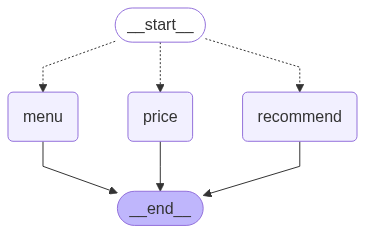

In [32]:

builder = StateGraph(GraphState)

builder.add_node("menu", handle_menu)
builder.add_node("price", handle_price)
builder.add_node("recommend", handle_recommend)

builder.add_conditional_edges(
    START,
    detect_query_type,
    {
        "menu": "menu",
        "price": "price",
        "recommend": "recommend"
    }
)

builder.add_edge("menu", END)
builder.add_edge("price", END)
builder.add_edge("recommend", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [33]:
initial_state = {
    "messages": [HumanMessage(content="카라멜 마키아토 설명해줘")],
}
final_state = graph.invoke(initial_state)

pprint(final_state["messages"][-1].content)


("'티라미수'를 추천해 드립니다.\n"
 '부드러운 마스카포네 치즈 크림과 에스프레소에 적신 레이디핑거 비스킷을 층층이 쌓아 만든 이탈리아 정통 디저트입니다. 고소한 카카오 '
 '파우더를 듬뿍 뿌려 풍미를 더했습니다. 커피의 쌉싸름함과 치즈의 부드러움이 조화롭게 어우러집니다.\n'
 '가격은 ₩9,000입니다.')
